<a href="https://colab.research.google.com/github/PradeepaArul/Optimization-Techniques/blob/main/Optimization_Techniques_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Importing Libraries***

In [ ]:
import time
from tensorflow import keras
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import Input

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ***Load Dataset***

In [ ]:
df = pd.read_csv('train.csv')
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


# ***Check for missing values***

In [ ]:
print('Missing values: \n', df.isnull().sum())

Missing values: 
 battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64


# ***Separate features and target variables***

In [ ]:
x = df.drop(columns = ['price_range'])
y = df['price_range']

# ***Scaling Features***

Normalize feature using StandardScaler

In [ ]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

# ***Splitting the Data***

Split data into training (80%) and testing (20%) sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print('Dataset loaded and preprocessed successfully!')

Dataset loaded and preprocessed successfully!


### ***Base Neural Network Model Creation***

Base Neural Network Model (Before EO)

In [ ]:
def create_nn(learning_rate=0.001, dropout_rate=0.3, num_neurons=64):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(num_neurons, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_neurons // 2, activation='relu'),
        Dropout(dropout_rate/2),
        Dense(4, activation='softmax')
      ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate = learning_rate),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# **Training the Base Neural Network**

Train baseline model (without EO) and evaluate

In [ ]:
baseline_model = create_nn()
history_baseline = baseline_model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data = (X_test, y_test), verbose=0)
baseline_acc = accuracy_score(y_test, np.argmax(baseline_model.predict(X_test), axis=1))
print(f'\nBaseline Neural Network Accuracy: {baseline_acc:.4f}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Baseline Neural Network Accuracy: 0.9375


# ***Equilibrium Optimizer (EO) Setup***

Equilibrium Optimizer for NN hyperparameters

In [ ]:
#EO parameters
NUM_PARTICLES = 10
DIM = 3
MAX_ITER = 20

In [ ]:
LR_MIN, LR_MAX = 0.0001, 0.01
DROPOUT_MIN, DROPOUT_MAX = 0.2, 0.5
NEURONS_MIN, NEURONS_MAX = 32, 128

Initialize particles

In [ ]:
population = np.random.uniform([LR_MIN, DROPOUT_MIN, NEURONS_MIN], [LR_MAX, DROPOUT_MAX, NEURONS_MAX], (NUM_PARTICLES, DIM))

Fitness function (minimize inverse accuracy)

In [ ]:
def evaluate_fitness(params):
    lr, dropout, neurons = params
    model = create_nn(learning_rate = lr, dropout_rate = dropout, num_neurons = int(neurons))
    model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test), verbose=0)
    y_pred = np.argmax(model.predict(X_test), axis=1)
    acc = accuracy_score(y_test, y_pred)
    return 1 - acc  # minimize error

In [ ]:
fitness = np.array([evaluate_fitness(ind) for ind in population])

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [ ]:
sorted_idx = np.argsort(fitness)
eq_candidates = population[sorted_idx[:4]]

In [ ]:
a1 = 2
GP = 0.5

EO Optimization

In [ ]:
for iteration in range(MAX_ITER):
    T = 1 - (iteration / MAX_ITER)

    for i in range(NUM_PARTICLES):
      Eq = eq_candidates[np.random.randint(0, 4)]
      r1, r2, r3, r4 = np.random.rand(4)
      lambda_val = r1 * (2 * np.random.rand() - 1)
      F = a1 * np.sign(r2 - 0.5) * (np.exp(-lambda_val * T) - 1)
      GCP = 0.5 * r3

      X_new = Eq + (population[i] - Eq) * F + GCP * (np.array([LR_MAX, DROPOUT_MAX, NEURONS_MAX]) - np.array([LR_MIN, DROPOUT_MIN, NEURONS_MIN]))
      X_new = np.clip(X_new, [LR_MIN, DROPOUT_MIN, NEURONS_MIN], [LR_MAX, DROPOUT_MAX, NEURONS_MAX])

      new_fitness = evaluate_fitness(X_new)
      if new_fitness < fitness[i]:
        population[i] = X_new
        fitness[i] = new_fitness

    sorted_idx = np.argsort(fitness)
    eq_candidates = population[sorted_idx[:4]]

    print(f'Iteration {iteration+1}: Best Accuracy = {1 - fitness[sorted_idx[0]]:.5f}')


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Iteration 1: Best Accuracy = 0.94000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Iteration 2: Best Accuracy = 0.94250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━

# ***Getting the Best Hyperparameters***

In [ ]:
best_solution = population[sorted_idx[0]]
best_lr, best_dropout, best_neurons = best_solution
best_neurons = int(best_neurons)

In [ ]:
print('\nBest Hyperparameters Found by EO: ')
print('Learning Rate:', best_lr)
print('Dropout Rate:', best_dropout)
print('Number of Neurons:', best_neurons)


Best Hyperparameters Found by EO: 
Learning Rate: 0.004357268075947493
Dropout Rate: 0.33391204003716685
Number of Neurons: 111


# ***Training the Optimized Neural Network***

In [ ]:
optimized_model = create_nn(learning_rate = best_lr, dropout_rate = best_dropout, num_neurons = best_neurons)
history_optimized = optimized_model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data = (X_test, y_test), verbose=0)

# ***Model Evaluation and Comparison***

Evaluate Optimized Model

In [ ]:
y_pred_optimized = np.argmax(optimized_model.predict(X_test), axis=1)
optimized_acc = accuracy_score(y_test, y_pred_optimized)
print(f"\nOptimized Model Accuracy: {optimized_acc:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Optimized Model Accuracy: 0.9075


Comparison : BaseLine vs EO-Optimized Model

In [ ]:
print('\nModel Comaparison:')
print(f'Baseline Model Accuracy: {baseline_acc:.4f}')
print(f'Optimized Model Accuracy: {optimized_acc:.4f}')


Model Comaparison:
Baseline Model Accuracy: 0.9325
Optimized Model Accuracy: 0.9075


# ***Plotting the Accuracy Comparison***

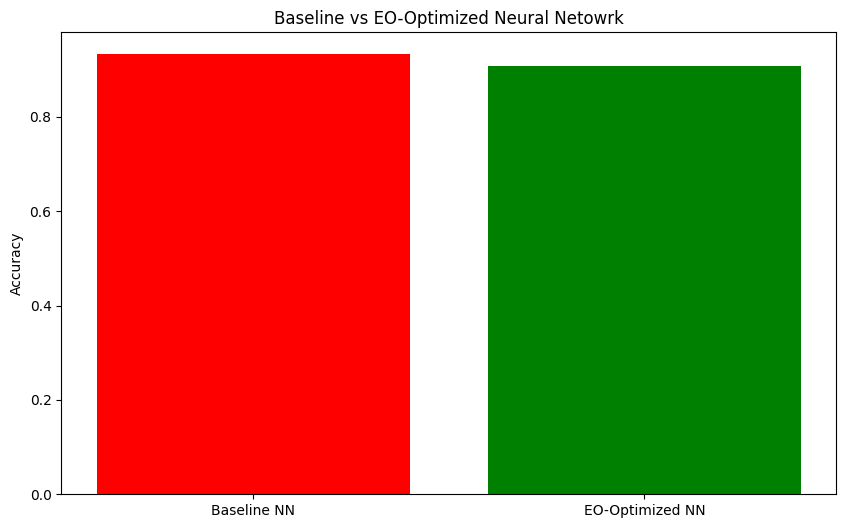

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(['Baseline NN', 'EO-Optimized NN'], [baseline_acc, optimized_acc], color = ['red', 'green'])
plt.ylabel('Accuracy')
plt.title('Baseline vs EO-Optimized Neural Netowrk')
plt.show()

# ***Performance Evaluation***

Predictions on test data(Baseline Model)

In [ ]:
y_pred_baseline = np.argmax(baseline_model.predict(X_test), axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Model Accuracy

In [ ]:
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print(f'Baseline Model Accuracy: {baseline_accuracy:.4f}')

Baseline Model Accuracy: 0.9325


Classification Report and plot accuracy over epochs

Classification Report for Baseline Model:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96       105
           1       0.95      0.89      0.92        91
           2       0.90      0.89      0.90        92
           3       0.94      0.95      0.94       112

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.93      0.93      0.93       400



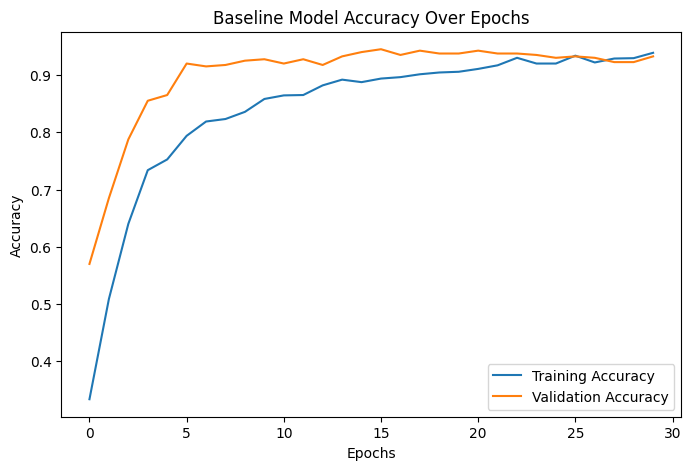

In [ ]:
print('Classification Report for Baseline Model:\n', classification_report(y_test, y_pred_baseline))
plt.figure(figsize = (8, 5))
plt.plot(history_baseline.history['accuracy'], label='Training Accuracy')
plt.plot(history_baseline.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Baseline Model Accuracy Over Epochs')
plt.show()

Predictions on test data(Optimized Model)

In [ ]:
y_pred_optimized = np.argmax(optimized_model.predict(X_test), axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Model Accuracy

In [ ]:
optimized_accuracy = accuracy_score(y_test, y_pred_optimized)
print(f'Optimized Model Accuracy: {optimized_accuracy:.4f}')

Optimized Model Accuracy: 0.9075


Classification Report and plot accuracy over epochs

Classification Report for Optimized Model:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95       105
           1       0.85      0.87      0.86        91
           2       0.92      0.78      0.85        92
           3       0.95      0.96      0.95       112

    accuracy                           0.91       400
   macro avg       0.91      0.90      0.90       400
weighted avg       0.91      0.91      0.91       400



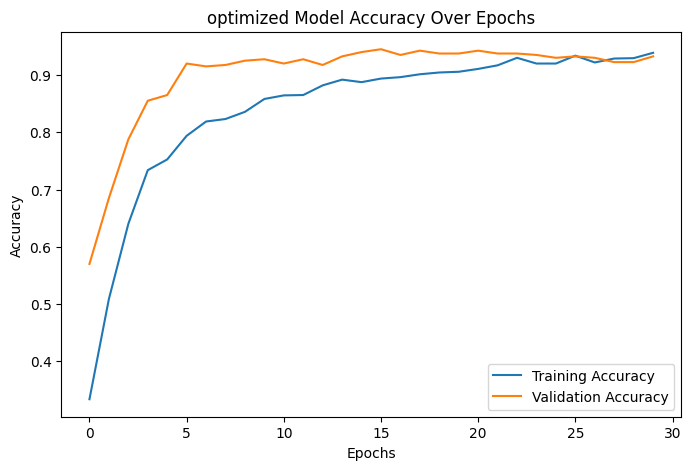

In [ ]:
print('Classification Report for Optimized Model:\n', classification_report(y_test, y_pred_optimized))
plt.figure(figsize = (8, 5))
plt.plot(history_baseline.history['accuracy'], label='Training Accuracy')
plt.plot(history_baseline.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('optimized Model Accuracy Over Epochs')
plt.show()

# ***Comparison with Traditional Machine Learning Models***

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

Train Logistic Regression Model

In [ ]:
log_reg = LogisticRegression(max_iter = 200)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
log_reg_acc = accuracy_score(y_test, y_pred_log_reg)
print(f'Logistic Regression Accuracy: {log_reg_acc:.4f}')

Logistic Regression Accuracy: 0.9775


Train Decision Tree Model

In [ ]:
dt = DecisionTreeClassifier(max_depth = 10, random_state = 42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
dt_acc = accuracy_score(y_test, y_pred_dt)
print(f'Decision Tree Accuracy: {dt_acc:.4f}')

Decision Tree Accuracy: 0.8350


Train Random Forest Model

In [ ]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {rf_acc:.4f}')

Random Forest Accuracy: 0.8925


Train SVM Model

In [ ]:
svm_model = SVC(kernel='rbf', C = 1.0)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
svm_acc = accuracy_score(y_test, y_pred_svm)
print(f'SVM Accuracy: {svm_acc:.4f}')

SVM Accuracy: 0.8925


Train Gradient Boost Model

In [ ]:
gb = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.1, random_state = 42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
gb_acc = accuracy_score(y_test, y_pred_gb)
print(f'Gradient Boosting Accuracy: {gb_acc:.4f}')

Gradient Boosting Accuracy: 0.9050


# ***Visualization and Results***


Comparison of All Models;
Baseline NN: 0.9325
EO-Optimized NN: 0.9075
Logistic Regression: 0.9775
Decision Tree: 0.8350
Random Forest: 0.8925
SVM: 0.8925
Gradient Boosting: 0.9050


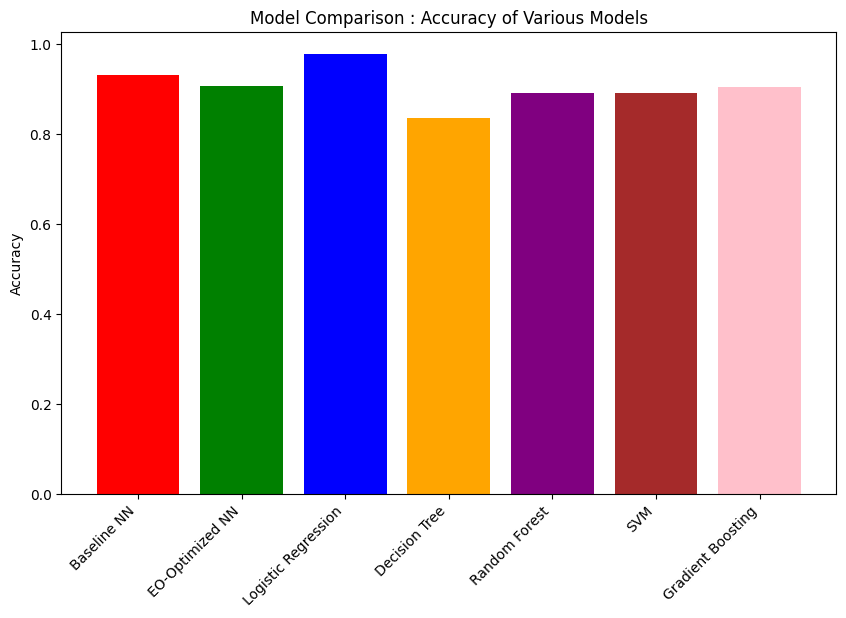

In [ ]:
models = {
    'Baseline NN': baseline_acc,
    'EO-Optimized NN': optimized_acc,
    'Logistic Regression': log_reg_acc,
    'Decision Tree': dt_acc,
    'Random Forest': rf_acc,
    'SVM': svm_acc,
    "Gradient Boosting": gb_acc
}

print('\nComparison of All Models;')
for model, acc in models.items():
    print(f'{model}: {acc:.4f}')

plt.figure(figsize = (10, 6))
plt.bar(models.keys(), models.values(), color = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink'])
plt.ylabel('Accuracy')
plt.title('Model Comparison : Accuracy of Various Models')
plt.xticks(rotation = 45, ha = 'right')
plt.show()

# ***Computational Efficiency***

In [ ]:
import time

***Baseline Model***

Record the time taken to train the model

In [ ]:
start_time = time.time()
baseline_model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data = (X_test, y_test), verbose=0)
baseline_training_time = time.time() - start_time

Record the time taken to make predictions for the baseline model

In [ ]:
start_time = time.time()
y_pred_baseline = np.argmax(baseline_model.predict(X_test), axis = 1)
baseline_prediction_time = time.time() - start_time

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Compute accuracy and computational efficiency for the baseline model

In [ ]:
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
baseline_efficiency = baseline_accuracy / (baseline_training_time + baseline_prediction_time)

***Optimized Model***

Record the time taken to train the model

In [ ]:
start_time = time.time()
optimized_model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data = (X_test, y_test), verbose=0)
optimized_training_time = time.time() - start_time

Record the time taken to make predictions for the baseline model

In [ ]:
start_time = time.time()
y_pred_optimized = np.argmax(optimized_model.predict(X_test), axis = 1)
optimized_prediction_time = time.time() - start_time

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Compute accuracy and computational efficiency for the baseline model

In [ ]:
optimized_accuracy = accuracy_score(y_test, y_pred_baseline)
optimized_efficiency = optimized_accuracy / (optimized_training_time + optimized_prediction_time)

**Print the results**

In [ ]:
print(f'Baseline Model Accuracy: {baseline_accuracy:.4f}')
print(f'Baseline Computaional Efficiency (Accuracy/Time): {baseline_efficiency:.4f} accuracy per second')
print(f'Optimized Model Accuracy: {optimized_accuracy:.4f}')
print(f'Optimized Computaional Efficiency (Accuracy/Time): {optimized_efficiency:.4f} accuracy per second')

Baseline Model Accuracy: 0.9325
Baseline Computaional Efficiency (Accuracy/Time): 0.0894 accuracy per second
Optimized Model Accuracy: 0.9325
Optimized Computaional Efficiency (Accuracy/Time): 0.0847 accuracy per second
